In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


In [208]:
#read excel file with columns to be used
df = pd.read_excel('Solaranlage_2020.xlsx', 
                    skiprows=3, usecols=['### UNIX-Zeitstempel',' Entladung(Wh)', ' Ladung(Wh)',
       ' Erzeugung(Wh)', ' Verbrauch(Wh)', ' Netz-Einspeisung(Wh)',
       ' Netz-Bezug(Wh)'], index_col='### UNIX-Zeitstempel')  
#rename columns without leading whitespace
original_columns = list(df.columns)
new_cols = []
for col in original_columns:
    new_cols.append(col.strip())
#create dict to rename cols
col_dict = dict(zip(original_columns, new_cols))
#set index as datetime 
df.index = pd.to_datetime(df.index, unit='s', utc=True).map(lambda x: x.tz_convert('Europe/Berlin'))
df.index.rename('Datum',inplace=True)
df.rename(columns=col_dict, inplace=True)
df.sort_index(inplace=True)  
#calculate kwh from Wh
kwh_df = df / 1000    
#rename columns to Kwh
for col in kwh_df.columns:
    kwh_df.rename(columns={col: col.replace('(Wh)','(Kwh)')}, inplace=True)
kwh_df.head()


,Entladung(Kwh),Ladung(Kwh),Erzeugung(Kwh),Verbrauch(Kwh),Netz-Einspeisung(Kwh),Netz-Bezug(Kwh)
Datum,,,,,,
2020-10-27 14:25:00+01:00,0.0,0.0,0.0,0.03038,0.0,0.03038
2020-10-27 14:30:00+01:00,0.0,0.0,0.0,0.03043,0.0,0.03043
2020-10-27 14:35:00+01:00,0.0,0.0,0.0,0.02784,0.0,0.02784
2020-10-27 14:40:00+01:00,0.0,0.0,0.0,0.02902,0.0,0.02902
2020-10-27 14:45:00+01:00,0.0,0.0,0.0,0.02839,0.0,0.02839


In [209]:
#umrechnung von Kwh in Kw

for col in kwh_df.columns:
    kwh_df[col[:-5]+'(kW)'] = kwh_df[col] / (5/60)

kwh_df.head()


,Entladung(Kwh),Ladung(Kwh),Erzeugung(Kwh),Verbrauch(Kwh),Netz-Einspeisung(Kwh),Netz-Bezug(Kwh),Entladung(kW),Ladung(kW),Erzeugung(kW),Verbrauch(kW),Netz-Einspeisung(kW),Netz-Bezug(kW)
Datum,,,,,,,,,,,,
2020-10-27 14:25:00+01:00,0.0,0.0,0.0,0.03038,0.0,0.03038,0.0,0.0,0.0,0.36456,0.0,0.36456
2020-10-27 14:30:00+01:00,0.0,0.0,0.0,0.03043,0.0,0.03043,0.0,0.0,0.0,0.36516,0.0,0.36516
2020-10-27 14:35:00+01:00,0.0,0.0,0.0,0.02784,0.0,0.02784,0.0,0.0,0.0,0.33408,0.0,0.33408
2020-10-27 14:40:00+01:00,0.0,0.0,0.0,0.02902,0.0,0.02902,0.0,0.0,0.0,0.34824,0.0,0.34824
2020-10-27 14:45:00+01:00,0.0,0.0,0.0,0.02839,0.0,0.02839,0.0,0.0,0.0,0.34068,0.0,0.34068


In [210]:
#wie viel wird erzeugt?
kwh_df['cumsum_erzeugung']=kwh_df['Erzeugung(kW)'].rolling(window=2).mean()


In [211]:
#direktverbrauch
kwh_df['direktverbrauch'] = np.where((kwh_df['Erzeugung(kW)'] >= kwh_df['Verbrauch(kW)']), kwh_df['Verbrauch(kW)'], 0) + np.where((kwh_df['Erzeugung(kW)'] <= kwh_df['Verbrauch(kW)']) & (kwh_df['Erzeugung(kW)'] > 0), kwh_df['Verbrauch(kW)']-(kwh_df['Verbrauch(kW)']-kwh_df['Erzeugung(kW)']), 0)


In [212]:
#pick a random single day from df
day = kwh_df['2020-11-06':'2020-11-06']
day.head()

,Entladung(Kwh),Ladung(Kwh),Erzeugung(Kwh),Verbrauch(Kwh),Netz-Einspeisung(Kwh),Netz-Bezug(Kwh),Entladung(kW),Ladung(kW),Erzeugung(kW),Verbrauch(kW),Netz-Einspeisung(kW),Netz-Bezug(kW),cumsum_erzeugung,direktverbrauch
Datum,,,,,,,,,,,,,,
2020-11-06 00:00:00+01:00,0.01463,0.0,0.0,0.01721,0.0,0.00258,0.17556,0.0,0.0,0.20652,0.0,0.03096,0.0,0.0
2020-11-06 00:05:00+01:00,0.01720,0.0,0.0,0.01988,0.0,0.00268,0.20640,0.0,0.0,0.23856,0.0,0.03216,0.0,0.0
2020-11-06 00:10:00+01:00,0.01376,0.0,0.0,0.01638,0.0,0.00262,0.16512,0.0,0.0,0.19656,0.0,0.03144,0.0,0.0
2020-11-06 00:15:00+01:00,0.01250,0.0,0.0,0.01512,0.0,0.00262,0.15000,0.0,0.0,0.18144,0.0,0.03144,0.0,0.0
2020-11-06 00:20:00+01:00,0.01417,0.0,0.0,0.01682,0.0,0.00265,0.17004,0.0,0.0,0.20184,0.0,0.03180,0.0,0.0


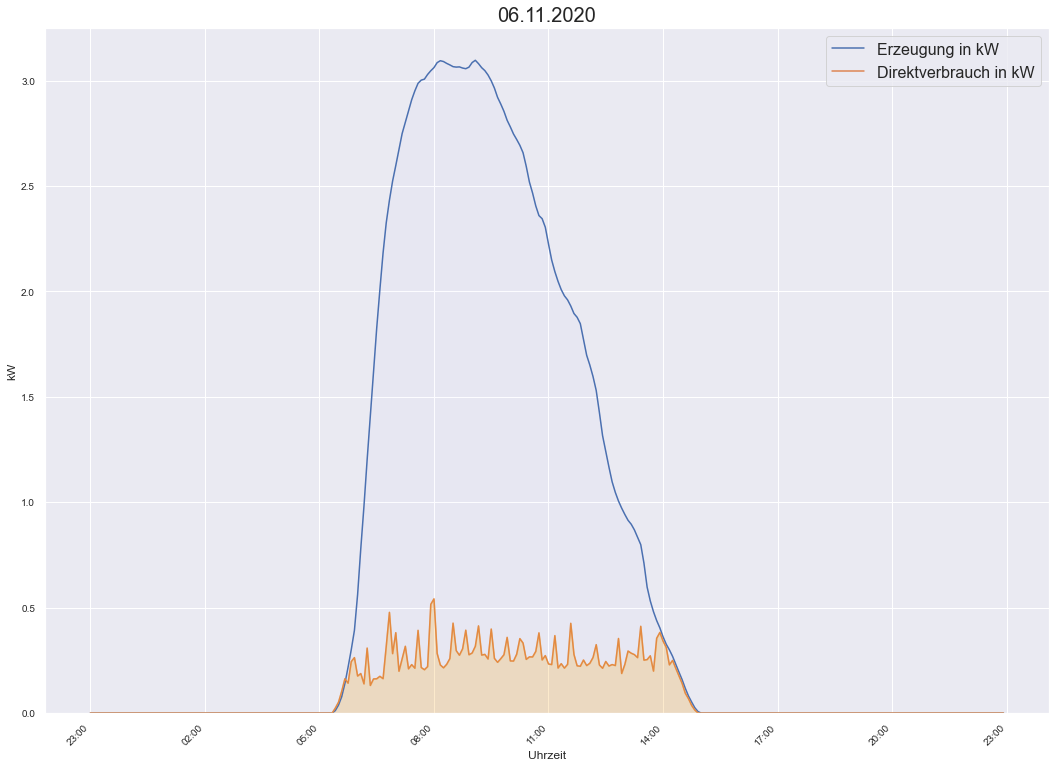

In [215]:
custom_params = {
                 'figure.figsize':(18,14),
                 "font.size":20,
                 "axes.titlesize":20,
                 "axes.labelsize":12,
                 "legend.fontsize":16,
                 "xtick.labelsize":10,
                 "ytick.labelsize":10}
sns.set_theme(style="darkgrid", rc=custom_params)
# Define the date format
date_form = DateFormatter("%H:%M")


fig, ax = plt.subplots()
#g0 = sns.lineplot(x="Datum", y=5, data=day, ax=ax, label='Maximale Ladung')
g1 = sns.lineplot(x='Datum', y='cumsum_erzeugung', data=day, ax=ax, label='Erzeugung in kW')
g2 = sns.lineplot(x='Datum', y='direktverbrauch', data=day, ax=ax, label='Direktverbrauch in kW')

#plot area under curve
day['cumsum_erzeugung'].plot.area(stacked=False, alpha=0.01, ax=ax, legend=False, color='blue')
day['direktverbrauch'].plot.area(stacked=False, alpha=0.2, ax=ax, legend=False, color='orange')


plt.title(day.index[0].strftime('%d.%m.%Y'))
ax.xaxis.set_major_formatter(date_form)
ax.set_xlabel('Uhrzeit')
plt.ylabel('kW')
plt.xticks(rotation=45)
plt.show()